# Lab 2: Diffusion Models Implementation
**Duration:** 3 hours  
**Objectives:**
- Implement and understand VAEs as foundation for diffusion
- Build simple diffusion process from scratch

In [1]:
# TODO: Make necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Import MNIST dataset
from torchvision import datasets, transforms

# TODO: Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Function to detect GPU, use CPU if not
def setup_device():
    """
    Automatically detect and setup the best available device(s)
    Returns device and whether multiple GPUs are available
    """
    
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        device = torch.device('cuda:0')
        
        print(f"GPU acceleration enabled!")
        print(f"   Available GPUs: {num_gpus}")

        for i in range(num_gpus):
            gpu_name = torch.cuda.get_device_name(i)
            gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1e9
            print(f"   GPU {i}: {gpu_name} ({gpu_memory:.1f}GB)") 

        multi_gpu = num_gpus > 1
        if multi_gpu:
            print(f"Multi-GPU training will be used ({num_gpus} GPUs)")
        return device, multi_gpu
    else:
        print("No GPU detected, using CPU")
        return torch.device('cpu'), False

In [3]:
# TODO: Set up compute device
device, multi_gpu = setup_device()
device_name = f"({device.type.upper()})" if not multi_gpu else f"(Multi-GPU)"

GPU acceleration enabled!
   Available GPUs: 4
   GPU 0: Tesla V100-SXM3-32GB (34.1GB)
   GPU 1: Tesla V100-SXM3-32GB (34.1GB)
   GPU 2: Tesla V100-SXM3-32GB (34.1GB)
   GPU 3: Tesla V100-SXM3-32GB (34.1GB)
Multi-GPU training will be used (4 GPUs)


### Exercise 1: Variational Autoencoder on MNIST

In [4]:
# TODO: Load MNIST dataset and create dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=[400,200], latent_dim=2):
        super(VAE, self).__init__()
        
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.fc_mu = nn.Linear(hidden_dim[1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim[1], latent_dim)
        
        # Decoder layers
        self.fc4 = nn.Linear(latent_dim, hidden_dim[1])
        self.fc5 = nn.Linear(hidden_dim[1], hidden_dim[0])
        self.fc6 = nn.Linear(hidden_dim[0], input_dim)
        
    def encode(self, x):
        """Encode input to latent distribution parameters"""
        
        #TODO: Implement encoder
        # 1. Pass x through fc1 with ReLU activation
        # 2. Compute mu using fc_mu
        # 3. Compute log_var using fc_logvar
        # 4. Return mu and log_var
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        h = F.leaky_relu(self.fc2(x), 0.2)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        """Reparameterization trick"""
        
        #TODO: Implement reparameterization
        # z = mu + eps * std, where eps ~ N(0,1)
        
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z
    
    def decode(self, z):
        """Decode latent representation back to data space"""
        
        #TODO: Implement decoder
        # 1. Pass z through fc3 with ReLU activation
        # 2. Pass through fc4 with sigmoid activation
        # 3. Return reconstructed output
        
        z = F.leaky_relu(self.fc4(z), 0.2)
        h = F.leaky_relu(self.fc5(z), 0.2)
        reconstruction = F.sigmoid(self.fc6(h))
        
        return reconstruction
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var

In [6]:
def vae_loss(reconstruction, original, mu, log_var):
    """
    VAE loss = Reconstruction loss + KL divergence
    """
    
    #TODO: Implement VAE loss
    # 1. Calculate BCE reconstruction loss (Because of MNIST dataset nature, MSE if continuous space)
    # 2. Calculate KL divergence: -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    # 3. Return total loss
    
    # Implement Reconstruction loss (Binary Cross Entropy)
    reconstruction_loss = F.binary_cross_entropy(reconstruction, original, reduction='sum')
    
    # Implement KL divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return reconstruction_loss + KLD

In [7]:
def train_vae(model, train_loader, epochs=10, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    train_losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(-1, 784).to(device)
            
            #TODO: Implement training step
            # 1. Zero gradients
            # 2. Forward pass
            # 3. Calculate loss
            # 4. Backward pass
            # 5. Update weights
            
            optimizer.zero_grad()
            reconstruction, mu, log_var = model(data)
            loss = vae_loss(reconstruction, data, mu, log_var)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    
    return train_losses

# Initialize and train VAE
vae_model = VAE(latent_dim=2).to(device)  # 2D latent for visualization
if multi_gpu:
    vae_model = nn.DataParallel(vae_model)
losses = train_vae(vae_model, train_loader, epochs=50)

Epoch 1/50, Loss: 180.3674
Epoch 2/50, Loss: 161.8262
Epoch 3/50, Loss: 157.4570
Epoch 4/50, Loss: 154.9716
Epoch 5/50, Loss: 153.2381
Epoch 6/50, Loss: 152.0069
Epoch 7/50, Loss: 150.7744
Epoch 8/50, Loss: 149.8826
Epoch 9/50, Loss: 149.0217
Epoch 10/50, Loss: 148.3896
Epoch 11/50, Loss: 147.8137
Epoch 12/50, Loss: 147.2661
Epoch 13/50, Loss: 146.7422
Epoch 14/50, Loss: 146.3938
Epoch 15/50, Loss: 145.9627
Epoch 16/50, Loss: 145.5851
Epoch 17/50, Loss: 145.3386
Epoch 18/50, Loss: 144.9611
Epoch 19/50, Loss: 144.6769
Epoch 20/50, Loss: 144.4605
Epoch 21/50, Loss: 144.2464
Epoch 22/50, Loss: 143.9696
Epoch 23/50, Loss: 143.6651
Epoch 24/50, Loss: 143.5403
Epoch 25/50, Loss: 143.2788
Epoch 26/50, Loss: 143.0911
Epoch 27/50, Loss: 142.9317
Epoch 28/50, Loss: 142.7771
Epoch 29/50, Loss: 142.5266
Epoch 30/50, Loss: 142.5496
Epoch 31/50, Loss: 142.1494
Epoch 32/50, Loss: 142.1655
Epoch 33/50, Loss: 141.9361
Epoch 34/50, Loss: 141.8029
Epoch 35/50, Loss: 141.6465
Epoch 36/50, Loss: 141.5767
E

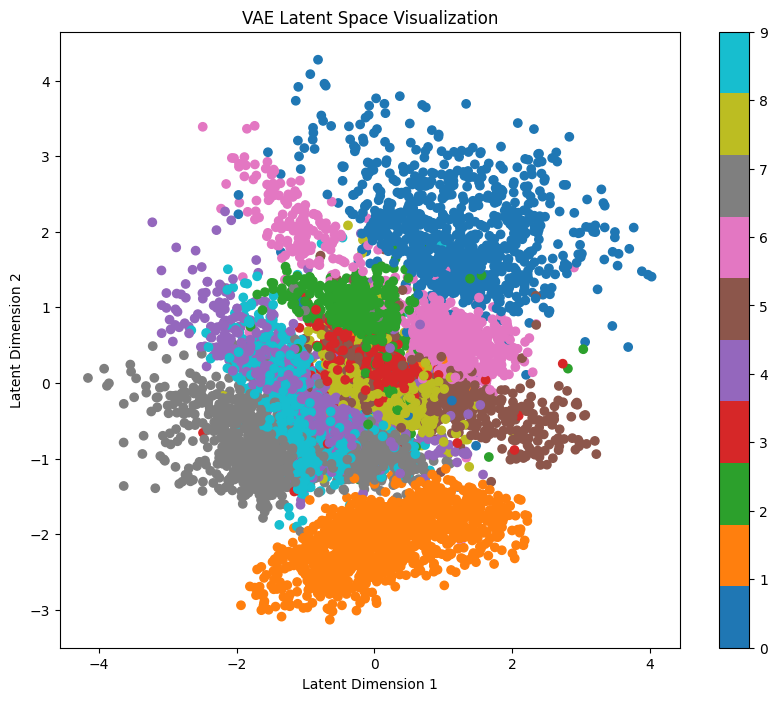

In [8]:
# Function to visualize the 2D latent space

def visualize_latent_space(model, test_loader):
    model.eval()
    latents = []
    labels = []
    
    with torch.no_grad():
        for data, label in test_loader:
            data = data.view(-1, 784).to(device)
            if multi_gpu:
                mu, _ = model.module.encode(data)
            else:
                mu, _ = model.encode(data)
            latents.append(mu.cpu().numpy())
            labels.append(label.numpy())
    
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('VAE Latent Space Visualization')
    plt.show()


visualize_latent_space(vae_model, test_loader)

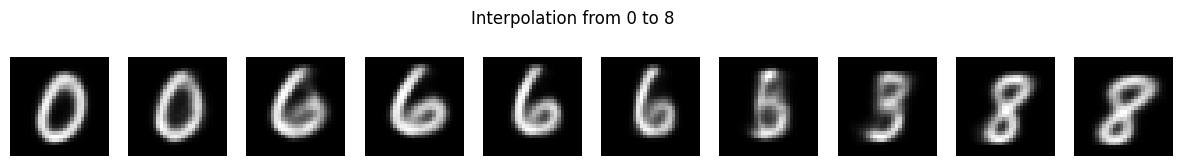

In [9]:
# Function to visualize latent interpolation between two digits
def interpolate_latent(model, start_digit=0, end_digit=9, n_steps=10):
    """Interpolate between two digits in latent space"""
    model.eval()
    
    # Get examples of start and end digits
    for data, labels in test_loader:
        start_idx = (labels == start_digit).nonzero()[0]
        end_idx = (labels == end_digit).nonzero()[0]
        break
    
    start_img = data[start_idx].view(-1, 784).to(device)
    end_img = data[end_idx].view(-1, 784).to(device)
    
    with torch.no_grad():
        # Encode to latent space
        if multi_gpu:
                start_mu, _ = model.module.encode(start_img)
                end_mu, _ = model.module.encode(end_img)
        else:
            start_mu, _ = model.encode(start_img)
            end_mu, _ = model.encode(end_img)
        
        # Interpolate
        fig, axes = plt.subplots(1, n_steps, figsize=(15, 2))
        for i, alpha in enumerate(np.linspace(0, 1, n_steps)):
            z = (1-alpha) * start_mu + alpha * end_mu
            if multi_gpu:
                reconstruction = model.module.decode(z)
            else:
                reconstruction = model.decode(z)
            
            axes[i].imshow(reconstruction.cpu().view(28, 28), cmap='gray')
            axes[i].axis('off')
        
        plt.suptitle(f'Interpolation from {start_digit} to {end_digit}')
        plt.show()

interpolate_latent(vae_model, 0, 8)

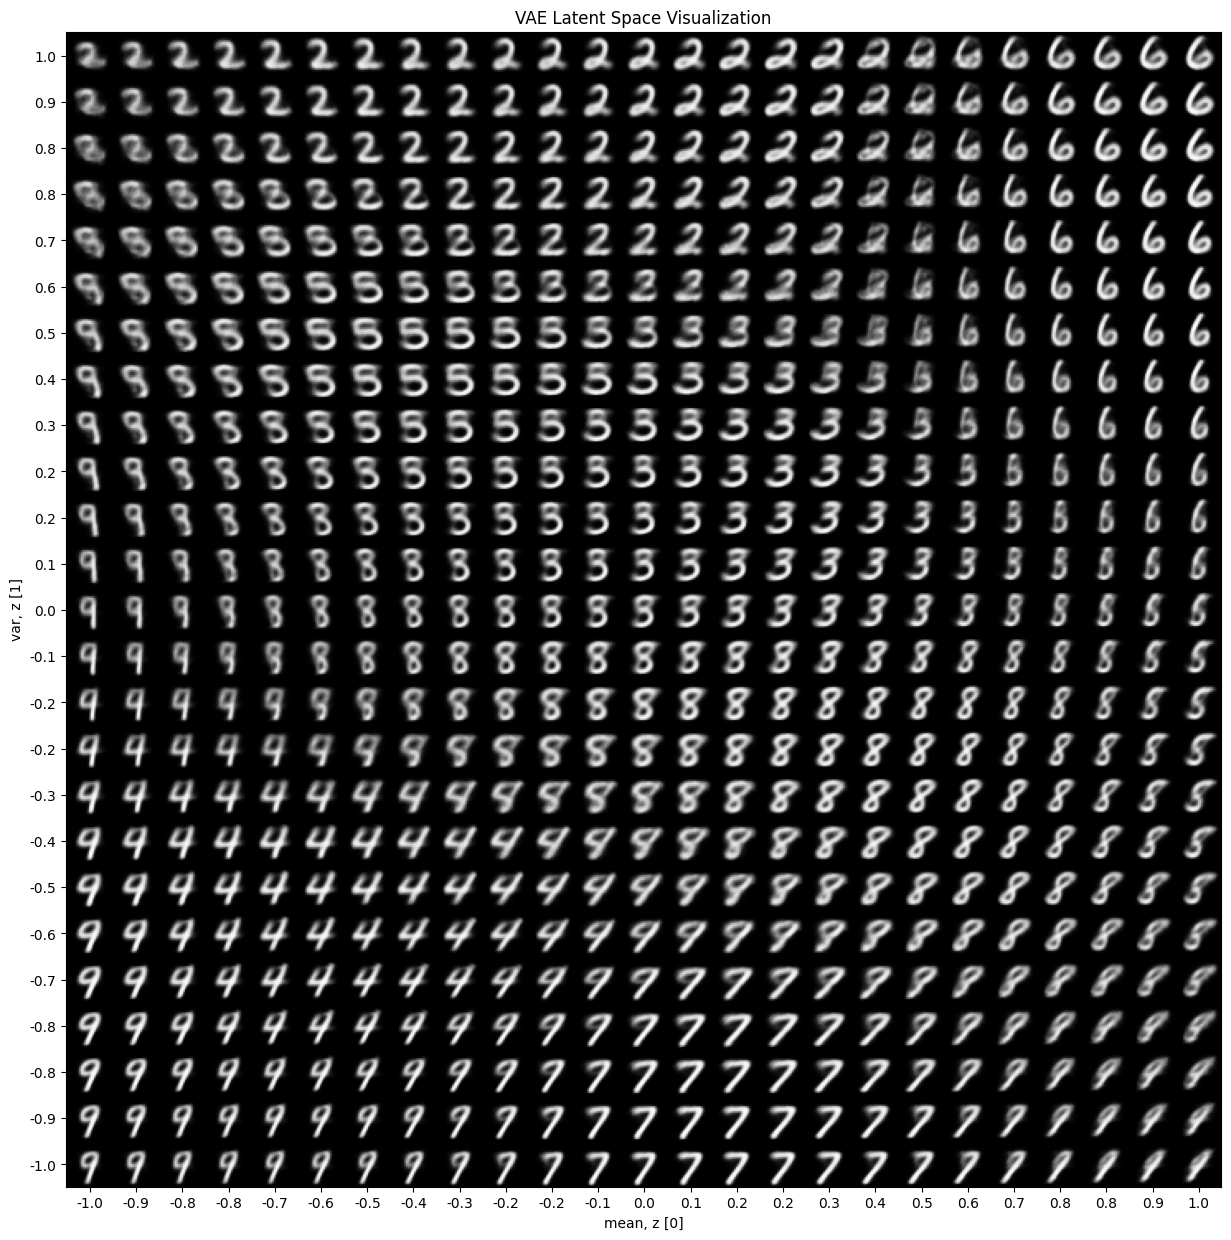

In [10]:
# Function to visualize latent interpolation
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            if multi_gpu:
                x_decoded = model.module.decode(z_sample)
            else:
                x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae_model)

### Exercise 2: Building Diffusion from Scratch

Now we'll implement a simple diffusion process on 1D data to understand the core concepts:

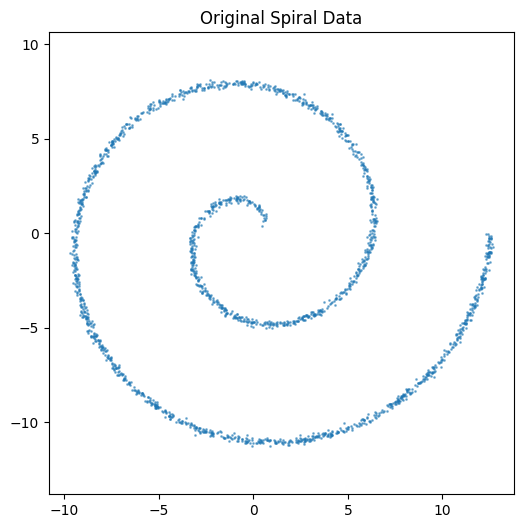

In [11]:
def generate_spiral_data(n_samples=1000):
    """Generate 2D spiral data for diffusion"""
    theta = np.sqrt(np.random.rand(n_samples)) * 4 * np.pi
    r = theta + np.random.randn(n_samples) * 0.1
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.stack([x, y], axis=1).astype(np.float32)

# Generate and visualize data
data = generate_spiral_data(2000)
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=1)
plt.title('Original Spiral Data')
plt.axis('equal')
plt.show()

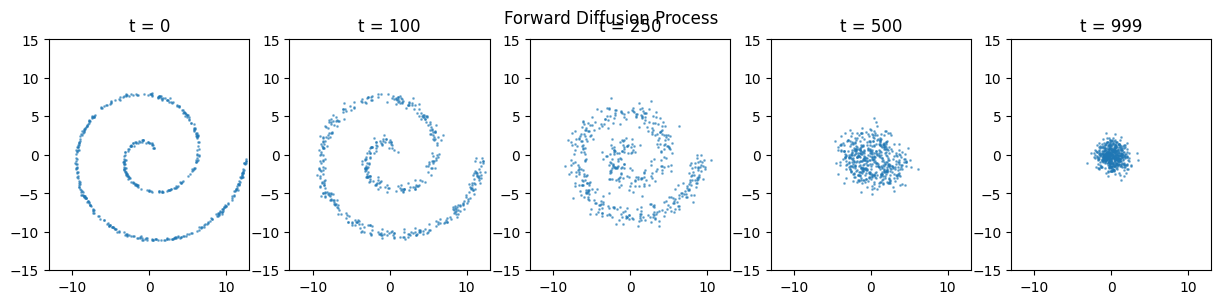

In [12]:
class ForwardDiffusion:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.num_timesteps = num_timesteps
        
        # Linear schedule for beta
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        # Pre-compute values for sampling
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)
    
    def add_noise(self, x_0, t):
        """Add noise to x_0 according to timestep t"""
        
        #TODO: Implement forward diffusion
        # x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * eps
        # where eps ~ N(0, 1)
        
        batch_size = x_0.shape[0]
        noise = torch.randn_like(x_0).to(device)
        
        # Gather the right alpha values for timestep t
        sqrt_alpha_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alpha_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        
        # Apply noise
        x_t = sqrt_alpha_t * x_0 + sqrt_one_minus_alpha_t * noise
        
        return x_t, noise

# Visualize forward process
forward_diff = ForwardDiffusion(num_timesteps=1000)
x_0 = torch.tensor(data[:500]).to(device)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
timesteps = [0, 100, 250, 500, 999]

for idx, t in enumerate(timesteps):
    t_tensor = torch.full((500,), t, dtype=torch.long)
    x_t, _ = forward_diff.add_noise(x_0, t_tensor)
    x_t_plot = x_t.cpu()
    axes[idx].scatter(x_t_plot[:, 0], x_t_plot[:, 1], alpha=0.5, s=1)
    axes[idx].set_title(f't = {t}')
    axes[idx].axis('equal')
    axes[idx].set_xlim(-15, 15)
    axes[idx].set_ylim(-15, 15)

plt.suptitle('Forward Diffusion Process')
plt.show()

In [13]:
class SimpleDenoiser(nn.Module):
    def __init__(self, data_dim=2, hidden_dim=128, time_dim=32):
        super().__init__()
        
        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )
        
        # Main network
        self.net = nn.Sequential(
            nn.Linear(data_dim + time_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, data_dim)
        )
    
    def forward(self, x, t):
        """Predict noise given noisy data x and timestep t"""
        
        #TODO: Implement forward pass
        # 1. Embed timestep
        # 2. Concatenate with x
        # 3. Pass through network
        
        # Normalize t to [0, 1]
        t_normalized = t.float().view(-1, 1) / 100.0
        t_emb = self.time_embed(t_normalized)
        
        # Concatenate x and time embedding
        x_with_time = torch.cat([x, t_emb], dim=1)
        
        # Predict noise
        predicted_noise = self.net(x_with_time)
        
        return predicted_noise

Epoch 500/5000, Loss: 0.587224
Epoch 1000/5000, Loss: 0.479020
Epoch 1500/5000, Loss: 0.504187
Epoch 2000/5000, Loss: 0.451163
Epoch 2500/5000, Loss: 0.423974
Epoch 3000/5000, Loss: 0.407220
Epoch 3500/5000, Loss: 0.541756
Epoch 4000/5000, Loss: 0.312534
Epoch 4500/5000, Loss: 0.479753
Epoch 5000/5000, Loss: 0.414742


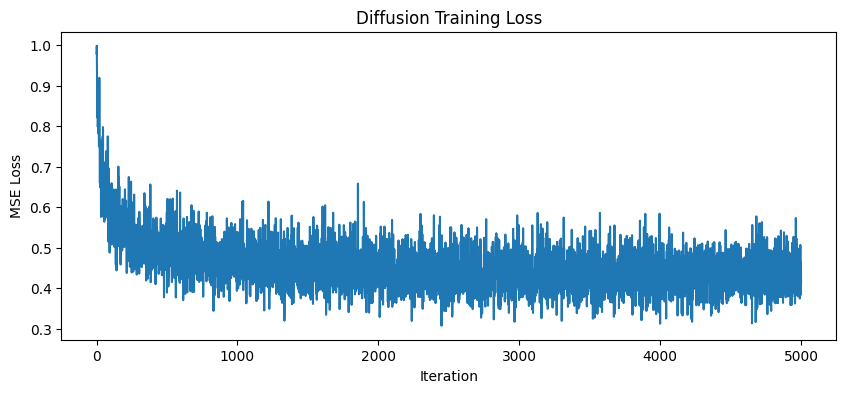

In [14]:
def train_diffusion(model, data, forward_diffusion, epochs=1000, batch_size=128, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    losses = []
    data_tensor = torch.tensor(data)
    
    for epoch in range(epochs):
        # Sample batch
        idx = torch.randint(0, len(data), (batch_size,))
        batch = data_tensor[idx].to(device)
        
        # Sample random timesteps
        t = torch.randint(0, forward_diffusion.num_timesteps, (batch_size,)).to(device)
        
        #TODO: Implement training step
        # 1. Add noise to batch using forward diffusion
        # 2. Predict noise using model
        # 3. Calculate MSE loss between true and predicted noise
        # 4. Backpropagate and update
        
        # Add noise
        noisy_batch, true_noise = forward_diffusion.add_noise(batch, t)
        noisy_batch = noisy_batch.to(device)
        true_noise = true_noise.to(device)
        
        # Predict noise
        predicted_noise = model(noisy_batch, t)
        
        # Calculate loss
        loss = F.mse_loss(predicted_noise, true_noise)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 500 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')
    
    return losses

# Train the model
denoiser = SimpleDenoiser().to(device)
if multi_gpu:
    denoiser = nn.DataParallel(denoiser)


losses = train_diffusion(denoiser, data, forward_diff, epochs=5000, batch_size=256)

plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Diffusion Training Loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.show()

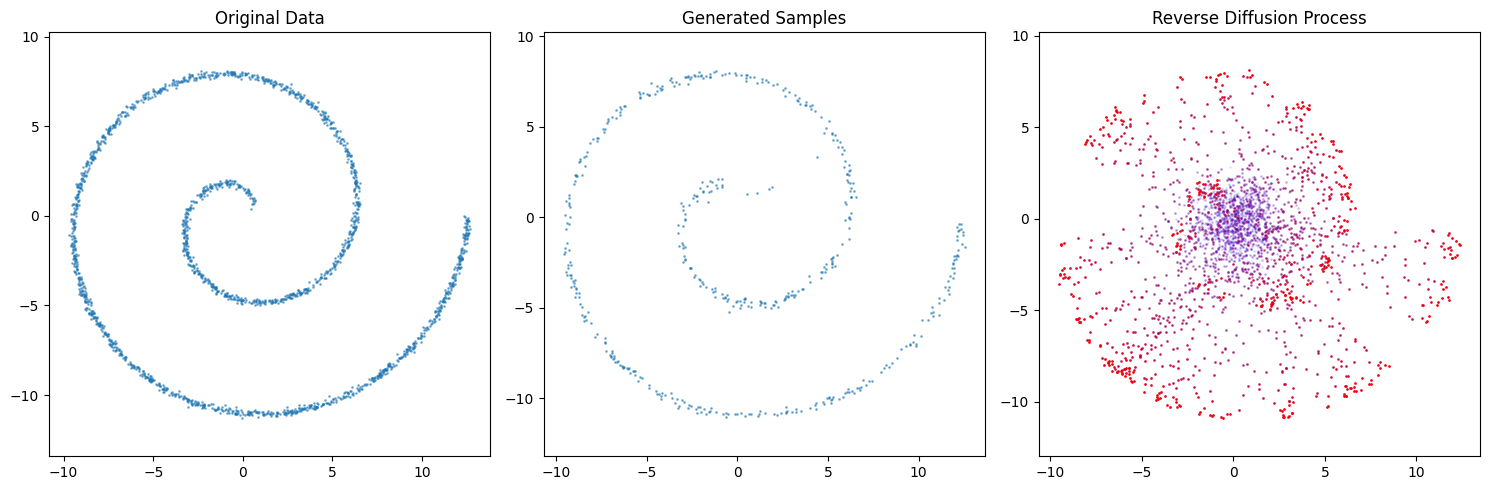

In [15]:
@torch.no_grad()
def sample_diffusion(model, forward_diffusion, n_samples=500):
    """Generate samples using reverse diffusion"""
    model.eval()
    
    # Start from pure noise
    x = torch.randn(n_samples, 2).to(device)
    
    # Store intermediate steps
    trajectory = [x.cpu().numpy()]
    
    # Reverse diffusion
    for t in reversed(range(forward_diffusion.num_timesteps)):
        t_batch = torch.full((n_samples,), t, device=device)
        
        #TODO: Implement reverse diffusion step
        # The reverse process approximates the posterior p(x_{t-1} | x_t) ≈ N(x_{t-1}; μ_θ(x_t, t), σ_t^2 I),
        # where μ_θ is the predicted mean derived from the model's noise prediction ε_θ(x_t, t),
        # and σ_t is the posterior variance.
        
        # 1. Predict noise using model:
        # The model ε_θ(x_t, t) estimates the noise ε that was added in the forward process.
        # This is trained to minimize the difference between predicted and actual noise.

        # 2. Compute parameters for the reverse step:
        # Gather α_t = 1 - β_t and ᾱ_t = ∏_{i=1}^t α_i
        # Compute posterior standard deviation σ_t:
        # For t > 0, σ_t = √[(1 - ᾱ_{t-1}) / (1 - ᾱ_t) * β_t],
        # which is the scaled variance from the DDPM posterior (often denoted as ~β_t).
        # At t=0, no additional noise is added (deterministic final step).
        
        # 2. Remove predicted noise (simplified DDPM equation)
        # Note: This is simplified - real DDPM has more complex sampling

        # 3. Compute the denoised mean μ_θ(x_t, t):
        # μ_θ = (1 / √α_t) * (x_t - ((1 - α_t) / √(1 - ᾱ_t)) * ε_θ(x_t, t))
        # This removes the predicted noise scaled by the forward process coefficients.

        # 4. Add posterior noise for sampling:
        # x_{t-1} = μ_θ + σ_t * z
        # This introduces the appropriate variance to match the reverse transition.

        # Note: This implements the standard DDPM sampling equation.
        # For deterministic sampling (e.g., DDIM), the noise term can be omitted or modified.
        # Variations may include different variance schedules or guidance.
        
        # Predict noise
        predicted_noise = model(x, t_batch)
        
        # Simplified denoising (not exact DDPM)
        alpha_t = forward_diffusion.alphas[t]
        alpha_cumprod_t = forward_diffusion.alphas_cumprod[t]
        
        if t > 0:
            alphacum_prev = forward_diffusion.alphas_cumprod[t-1]
            sigma = ((1 - alphacum_prev) / (1 - alpha_cumprod_t) * forward_diffusion.betas[t]) ** 0.5
            noise = torch.randn_like(x)
        else:
            sigma = 0
            noise = 0
        
        x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_cumprod_t).sqrt() * predicted_noise)
        x = x + sigma * noise
        
        if t % 20 == 0:
            trajectory.append(x.cpu().numpy())
    
    return x.cpu().numpy(), trajectory

# Generate samples
samples, trajectory = sample_diffusion(denoiser, forward_diff)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(data[:, 0], data[:, 1], alpha=0.5, s=1)
axes[0].set_title('Original Data')
axes[0].axis('equal')

axes[1].scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=1)
axes[1].set_title('Generated Samples')
axes[1].axis('equal')

# Show trajectory
axes[2].set_title('Reverse Diffusion Process')
for i, step in enumerate(trajectory[::2]):
    alpha = i / len(trajectory[::2])
    axes[2].scatter(step[:100, 0], step[:100, 1], alpha=alpha, s=1, c=[[alpha, 0, 1-alpha]])
axes[2].axis('equal')

plt.tight_layout()
plt.show()